### Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### Implementação dos Modelos Lineares de Aprendizagem de Máquina

In [2]:
class PerceptronLA:
    def __init__(self, _X, _Y):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
    
    def fit(self):

        self.W = np.zeros(self.X.shape[1])
        indice_class_incorretas = np.arange(len(self.X))

        while (len(indice_class_incorretas) > 0):
            indice_aleatorio = np.random.choice(indice_class_incorretas)

            self.W = self.W + (self.Y[indice_aleatorio] * self.X[indice_aleatorio])

            lista_provisoria = []

            for i in range(len(self.X)):
                classificacao_atual = np.sign(self.W @ self.X[i])

                if classificacao_atual != self.Y[i]:
                    lista_provisoria.append(i)
            
            indice_class_incorretas = np.array(lista_provisoria)
    
    def predict(self, _X):
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.PREDICT = []

        for x in X:
            self.PREDICT.append(np.sign(self.W @ x))

        self.PREDICT = np.array(self.PREDICT)

In [3]:
class RegressaoLinear:
    def __init__(self, _X, _Y):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
    
    def fit(self):

        matriz_XtX = self.X.T @ self.X
        inversa_matriz_XtX = np.linalg.inv(matriz_XtX)
        matriz_XtY = self.X.T @ self.Y
        
        self.W = inversa_matriz_XtX @ matriz_XtY
    
    def predict(self, _X):
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.PREDICT = []

        for x in X:
            self.PREDICT.append(np.sign(self.W @ x))

        self.PREDICT = np.array(self.PREDICT)

In [23]:
class RegressaoLogistica:
    def __init__(self, _X, _Y, eta = 0.1, tmax = 1000):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
        self.eta = eta
        self.tmax = tmax

    def fit(self):

        self.W = np.zeros(self.X.shape[1])

        for t in range(self.tmax):
            
            somatorio = np.zeros(self.X.shape[1])

            for i in range(self.X.shape[0]):
                exponencial = np.exp(self.Y[i]*(self.W @ self.X[i]))
                somatorio += (self.Y[i]*self.X[i]) / (1 + exponencial)
            
            gradiente = -(1/self.X.shape[0]) * somatorio

            if np.linalg.norm(gradiente) < 0.00000000000001 :
                break

            self.W = self.W - (self.eta * gradiente)

    def predict_prob(self, _X):
        self.PROB = []

        for x in _X:
            z = x @ self.W
            self.PROB.append(1 / (1 + np.exp(-z)))
            
        self.PROB = np.array(self.PROB)

    def predict(self, _X):
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.predict_prob(X)
        self.PREDICT = np.empty(len(self.PROB), dtype = int)

        for i in range(len(self.PROB)):
            if self.PROB[i] >= 0.5:
                self.PREDICT[i] = 1
            else:
                self.PREDICT[i] = -1

### Classificação dos Dígitos 1x5

Filtrando os dados de treino e teste onde o campo "label" seja 1 ou 5, ou seja, onde aquele dado represente o dígito 1 ou o dígito 5

In [5]:
train_redu = pd.read_csv("DatasetProjeto1/train_redu.csv")
test_redu = pd.read_csv("DatasetProjeto1/test_redu.csv")

train1x5 = train_redu[train_redu["label"].isin([1,5])].copy()
test1x5 = test_redu[test_redu["label"].isin([1,5])].copy()

scaler = MinMaxScaler()

train1x5[["intensidade", "simetria"]] = scaler.fit_transform(train1x5[["intensidade", "simetria"]])
test1x5[["intensidade", "simetria"]] = scaler.transform(test1x5[["intensidade", "simetria"]])

Plotando os dados de treino

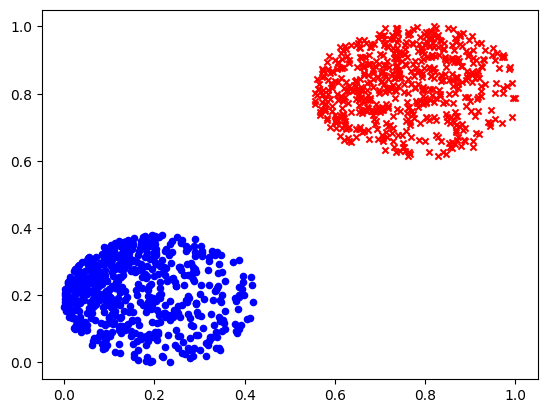

In [6]:
label1 = train1x5[train1x5["label"] == 1]
label5 = train1x5[train1x5["label"] == 5]

plt.scatter(label1["intensidade"], label1["simetria"], color='blue', marker='o', s=20)
plt.scatter(label5["intensidade"], label5["simetria"], color='red', marker='x', s=20)

Construindo o vetor X = {(intensidade, simetria)} e o vetor Y com valor +1 para as imagens com valor label = 1 e o valor -1 para as imagens com valor label = 5 

In [7]:
X = train1x5[["intensidade", "simetria"]].to_numpy()
Y = train1x5["label"].map({1: 1, 5: -1}).to_numpy()

Treinando os três classificadores com os dados de train1x5

In [24]:
PLAclass = PerceptronLA(X, Y)
RLclass = RegressaoLinear(X, Y)
RLOclass = RegressaoLogistica(X, Y)

PLAclass.fit()
RLclass.fit()
RLOclass.fit()

In [25]:
print(PLAclass.W)
print(RLclass.W)
print(RLOclass.W)

[ 1.         -1.01228014 -1.11403097]
[ 1.54070954 -1.37154164 -1.76466448]
[ 3.66752332 -3.92046015 -3.98582128]


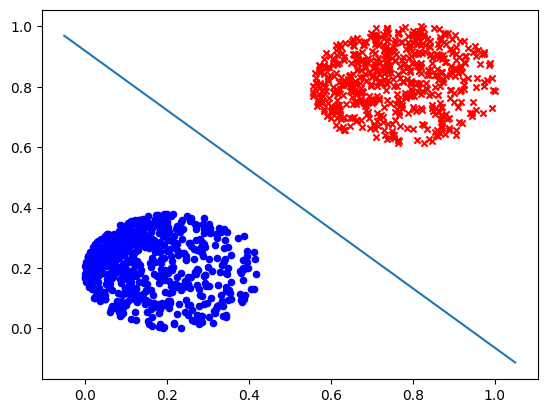

In [27]:
plt.scatter(label1["intensidade"], label1["simetria"], color='blue', marker='o', s=20)
plt.scatter(label5["intensidade"], label5["simetria"], color='red', marker='x', s=20)

b  = RLOclass.W[0]
w1 = RLOclass.W[1]
w2 = RLOclass.W[2]

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 200)

y = -(w1/w2)*x - (b/w2)

plt.plot(x, y)
plt.show()